# Basic depth map processing

In [1]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary

### Visualization

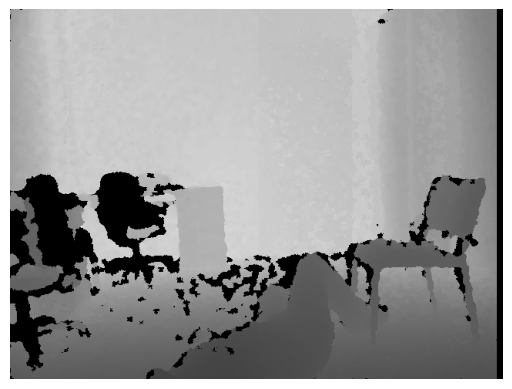

In [2]:
label = 'fall' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:
    frame = cv2.imread(str(frame_path))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis("off")
    plt.show()

# Dataset

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.sequences = []
        self.transform = transform
        self.number_of_frames = 256

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                if seq_folder.is_dir():
                    frames = sorted(seq_folder.glob("*.png"))
                    imgs = []
                    for f in frames:
                        img = Image.open(f).convert("RGB")
                        if self.transform:
                            img = self.transform(img)
                        imgs.append(img)
                    self.sequences.append((imgs, label_idx))
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        imgs, label = self.sequences[idx]  # tu imgs to już lista tensorów
        T = len(imgs)

        if T >= self.number_of_frames:
            imgs = imgs[-self.number_of_frames:]
        else:
            pad = self.number_of_frames - T
            first = imgs[0]
            imgs = [first for _ in range(pad)] + imgs  # padding na początku

        video_tensor = torch.stack(imgs)  # (T, C, H, W)
        return video_tensor, label



In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
root_dir = Path('../datasets')

dataset = VideoDataset(root_dir, transform)

### Model

In [5]:
class CNN_LSTM(nn.Module):
    def __init__(self, cnn_model='resnet18', hidden_size=256, num_classes=2, pretrained=True):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(pretrained=pretrained)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        """
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)
        

        cnn_features = torch.stack(cnn_features, dim=1)
        
        # LSTM
        lstm_out, _ = self.lstm(cnn_features) 

        # Last timestep: (B, hidden_size)
        last_time_step = lstm_out[:, -1, :] 

        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [6]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

# summary(model, input_size=(2, 256, 3, 224, 224), device=device)

/home/user/miniconda3/envs/ur-fall/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/miniconda3/envs/ur-fall/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from sklearn.model_selection import train_test_split


num_epochs = 10
batch_size = 4

indices = list(range(len(dataset)))
labels = [dataset[i][1] for i in indices]
train_idx, val_idx = train_test_split(indices, test_size=0.15, stratify=labels, random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)


checkpoint_dir = Path('../models')
checkpoint_dir.mkdir(exist_ok=True, parents=True)
best_val_loss = 1e10

for epoch in range(num_epochs):
    # ===================== TRAIN =====================
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for i, (videos, labels) in enumerate(train_loader):
        videos = videos.to(device)   # (B, T, C, H, W)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)      # (B, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * videos.size(0)

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_dataset)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] TRAIN -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # ===================== VALIDATION =====================
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * videos.size(0)

            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] VAL   -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # ===================== CHECKPOINT =====================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = checkpoint_dir / f'best_model_basic_depth.pt'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"\tSaved")


Epoch [1/10] TRAIN -> Loss: 0.7140, Accuracy: 55.93%
Epoch [1/10] VAL   -> Loss: 0.6426, Accuracy: 72.73%
	Saved
Epoch [2/10] TRAIN -> Loss: 0.6154, Accuracy: 76.27%
Epoch [2/10] VAL   -> Loss: 0.5516, Accuracy: 72.73%
	Saved
Epoch [3/10] TRAIN -> Loss: 0.4792, Accuracy: 89.83%
Epoch [3/10] VAL   -> Loss: 0.4453, Accuracy: 100.00%
	Saved
Epoch [4/10] TRAIN -> Loss: 0.5374, Accuracy: 74.58%
Epoch [4/10] VAL   -> Loss: 0.3892, Accuracy: 81.82%
	Saved
Epoch [5/10] TRAIN -> Loss: 0.3187, Accuracy: 93.22%
Epoch [5/10] VAL   -> Loss: 0.2077, Accuracy: 100.00%
	Saved
Epoch [6/10] TRAIN -> Loss: 0.2232, Accuracy: 91.53%
Epoch [6/10] VAL   -> Loss: 0.1916, Accuracy: 100.00%
	Saved
Epoch [7/10] TRAIN -> Loss: 0.2433, Accuracy: 93.22%
Epoch [7/10] VAL   -> Loss: 0.1196, Accuracy: 100.00%
	Saved
Epoch [8/10] TRAIN -> Loss: 0.3696, Accuracy: 81.36%
Epoch [8/10] VAL   -> Loss: 0.2011, Accuracy: 100.00%
Epoch [9/10] TRAIN -> Loss: 0.1263, Accuracy: 96.61%
Epoch [9/10] VAL   -> Loss: 0.1070, Accuracy:

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%


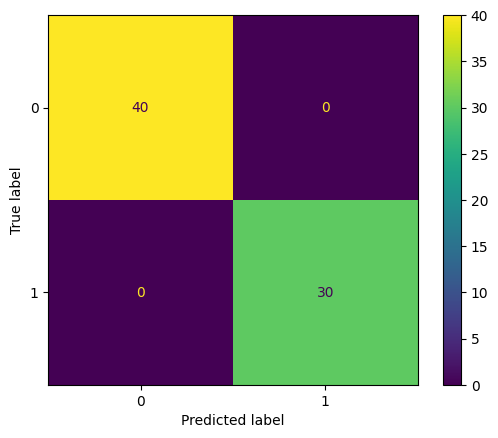

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import torch

# Wczytanie najlepszego modelu
best_model_path = checkpoint_dir / 'best_model_basic_depth.pt'
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for videos, labels in DataLoader(dataset, batch_size=4, shuffle=False):
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = model(videos)               # (B, num_classes)
        _, predicted = torch.max(outputs, 1)  # (B,)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary')
rec = recall_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall: {rec*100:.2f}%")

ConfusionMatrixDisplay(cm).plot()